<a href="https://colab.research.google.com/github/huongdg/Apache-Spark-2x-for-Java-Developers/blob/master/GCN%2BCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!rm -r /content/sample_data

Mounted at /content/drive


In [ ]:
# https://stackoverflow.com/questions/55233377/keras-sequential-model-with-multiple-inputs/55234203
# https://stackoverflow.com/questions/45979848/merge-2-sequential-models-in-keras
# https://antonsruberts.github.io/graph/gcn/
# https://stackoverflow.com/questions/55233377/keras-sequential-model-with-multiple-inputs

In [10]:
pip install stellargraph[demos]

     |████████████████████████████████| 435 kB 5.3 MB/s 
     |████████████████████████████████| 407 kB 39.4 MB/s 
     |████████████████████████████████| 45 kB 3.5 MB/s 
  Created wheel for mplleaflet: filename=mplleaflet-0.0.5-py3-none-any.whl size=28581 sha256=9b3d9c3cc7fa4a8c93fb6c3457c9983f566e233786ae9876bd11e95899522700
  Stored in directory: /root/.cache/pip/wheels/6b/f5/21/cdd12e476182b4b0b98326cdb9efa02ddbd5d87ca5de051c84
Successfully built mplleaflet


In [11]:
import pandas as pd
import numpy as np
import stellargraph as sg
n_node_feature = 69+64+1
n_node_max = 100
np.random.seed(10)
n_class = 2
n_edge_type = 13

In [ ]:
def get_graph(node_data, edge_data):
  temp = node_data.drop("key", axis=1).to_numpy()
  features = np.zeros((n_node_max,n_node_feature))
  features[:temp.shape[0],:temp.shape[1]] = temp
  # features = node_data.drop("key", axis=1).to_numpy()
  adjacency = np.zeros((n_node_max,n_node_max),np.int64)
  inds = zip(edge_data.start.astype(np.int64).to_list(), edge_data.end.astype(np.int64).to_list())
  adjacency[edge_data.start.astype(np.int64).to_list()][edge_data.end.astype(np.int64).to_list()] += 1
  return features ,adjacency

def get_img(node_data, edge_data):
  # w_size = nodes.shape[0]
  # n_w = edge_data.shape[1]-2
  # img = np.zeros((w_size,w_size,n_w))
  img = np.zeros((n_node_max,n_node_max,n_edge_type))
  data = edge_data.drop(["start", "end"], axis = 1).to_numpy()
  for index, row in edge_data[["start", "end"]].astype(np.int32).iterrows():
    start, end = row["start"], row["end"]
    img[start][end] = data[index]
  return img


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling1D,Input,concatenate,Concatenate
from stellargraph.layer.gcn import GraphConvolution

def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(n_node_max,n_node_max,n_edge_type)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    return model

def create_gcn_model():
    x_features = Input(shape=( n_node_max, n_node_feature))
    x_adjacency = Input(shape=( n_node_max, n_node_max))
    out = Dropout(0.5)(x_features)
    out = GraphConvolution(32, activation='relu', 
                        use_bias=True
                        )([out, x_adjacency])
    out = Dropout(0.5)(out)
    out = GraphConvolution(32, activation='relu', 
                        use_bias=True
                        )([out, x_adjacency])

    out = GlobalAveragePooling1D()(out)
    out = Flatten()(out)
    model = Model(inputs=[x_features, x_adjacency], outputs=out)

    return model

In [ ]:
def create_model() : 
  model1 = create_cnn_model()
  model2 = create_gcn_model()

  
  out = Concatenate()([model1.output,model2.output])
  out = Flatten()(out)    
  out = Dense(256, activation='relu')(out)
  out = Dropout(.5)(out)
  out = Dense(128, activation='relu')(out)
  out = Dense(n_class, activation='softmax')(out)

  model = Model([model1.input,model2.input], out)
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model


In [ ]:
# def train_test_split(ls_img,ls_feature, ls_adjacency,labels, ind_test ,ind_train):
#   X_test = [ls_img[ind_test],ls_feature[ind_test],ls_adjacency[ind_test]]
#   Y_test = labels[ind_test]
#   X_train = [ls_img[ind_train],ls_feature[ind_train],ls_adjacency[ind_train]]
#   Y_train = labels[ind_train]
#   return X_test, Y_test, X_train, Y_train

In [ ]:
# import os
# from keras.utils.np_utils import to_categorical  
# def load_dataset(input_path,test_size) :
#   # full_data = pd.read_json(full_info_path)[["file_path", "label"]]
#   # full_data.file_path = full_data.file_path.apply(lambda x: x.split("/")[-1])
#   # full_data = full_data.set_index("file_path")
#   ls_feature = []
#   ls_adjacency = []
#   ls_img = []
#   labels = []
#   for root, dirs, files in os.walk(input_path, topdown=False):
#     for dir in dirs:
#         if ".c" in dir :
#           try:
#             node_data = pd.read_csv(os.path.join(root, dir, "nodes.csv"))
#             edge_data = pd.read_csv(os.path.join(root, dir, "edges.csv"))
#             features, adjacency = get_graph(node_data, edge_data)
#             img = get_img(node_data, edge_data)
#             labels.append(1 if "_1.c" in dir else 0)
#           except:
#             continue
          
#           ls_feature.append(features)
#           ls_adjacency.append(adjacency)
#           ls_img.append(img)
#   # return [np.array(ls_img), np.array(ls_feature), np.array(ls_adjacency)], to_categorical(labels,num_classes = full_data.label.to_numpy().max()+1)
#   inds = np.arange(len(labels))
#   np.random.shuffle(inds)    
#   n_test = int(len(labels)*test_size )  
#   ind_test = inds[:n_test] 
#   ind_train = inds[n_test:]
#   return train_test_split(np.array(ls_img), np.array(ls_feature), np.array(ls_adjacency), to_categorical(labels,num_classes = 2), ind_test, ind_train)

In [24]:
import os
from keras.utils.np_utils import to_categorical  
def load_data(root_path,samples) :
  ls_feature = []
  ls_adjacency = []
  ls_img = []
  labels = []
  for sample in samples:
      try:
        node_data = pd.read_csv(os.path.join(root, sample, "nodes.csv"))
        edge_data = pd.read_csv(os.path.join(root, sample, "edges.csv"))
        features, adjacency = get_graph(node_data, edge_data)
        img = get_img(node_data, edge_data)
        labels.append(1 if "_1.c" in dir else 0)
      except:
        continue
        ls_feature.append(features)
        ls_adjacency.append(adjacency)
        ls_img.append(img)
  return [np.array(ls_img), np.array(ls_feature), np.array(ls_adjacency)], to_categorical(labels,num_classes = 2)

  

In [36]:
def split_dataset(test_size, val_size, full_data_paths):
  # samples = pd.read_json("/content/drive/MyDrive/do-an/chrome_debian_full_data_with_slices.json").file_path.apply(lambda x: x.split("/")[-1]).to_list()
  samples = pd.read_json(full_data_paths).file_path.apply(lambda x: x.split("/")[-1]).to_numpy()
  n_sample = samples.shape[0]
  inds = np.arange(n_sample)
  np.random.shuffle(inds)
  if (not type(test_size) is float) or  (not type(val_size) is float):
    raise TypeError()
  if test_size <= 0 or test_size > 1 or val_size <= 0 or val_size > 1:
    raise Exception()

  test_lim = int(n_sample*test_size)
  val_lim = int(n_sample*(test_size+(1-test_size)*val_size))
  return samples[inds[:test_lim]], samples[inds[test_lim:val_lim]], samples[inds[val_lim:]]


In [ ]:
!unrar x "/content/drive/MyDrive/do-an/final_final.rar" "/content/demo/"

In [ ]:
# X_test, Y_test, X_train, Y_train = load_dataset("/content/demo/", 0.2)

In [ ]:
# checkpoint_filepath = '/content/drive/MyDrive/do-an/model/gcn+cnn_final_final/checkpoint_9_10.hdf5'
# model = create_model()
# # monitor="val_loss"
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_accuracy',save_best_only=True)
# history = model.fit( x = X_train, y = Y_train, batch_size=10, epochs=100,callbacks = [model_checkpoint_callback], validation_split = 0.2)

In [37]:
test_sapmles, val_samples, train_samples = split_dataset(0.2, 0.2, "/content/drive/MyDrive/do-an/chrome_debian_full_data_with_slices.json")
val_data, val_label = load_data("/content/demo/final_final",val_samples)

In [29]:
checkpoint_filepath = '/content/drive/MyDrive/do-an/model/gcn+cnn_final_final/checkpoint_9_10.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_accuracy',save_best_only=True)
model = create_model()
for i in range(int(train_sample.shape[0]/1000 + 1)) :
  x, y = load_data("/content/demo/final_final",val_samples[i+1000:(i+1)*1000])
  model.fit( x = x, y = y, batch_size=10, epochs=100,callbacks = [model_checkpoint_callback], val_data = val_data, val_label = val_label)
  del x
  del y


In [ ]:
from sklearn.metrics import *

model = create_model()
model.load_weights(checkpoint_filepath)

del val_data if val_data in globals()
del val_label if val_label in globals()

X_test, Y_test = load_data("/content/demo/final_final",test_sapmles)

y_pred = model.predict(X_test).argmax(axis = 1)
y_true =Y_test.argmax(axis = 1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       432
           1       0.90      0.97      0.93       172

    accuracy                           0.96       604
   macro avg       0.94      0.96      0.95       604
weighted avg       0.96      0.96      0.96       604



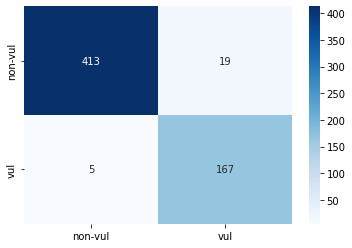

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(matrix, annot=True, fmt='.0f', cmap='Blues', yticklabels=['non-vul', 'vul'],xticklabels=['non-vul', 'vul'])
# plt.xlabel("Predicted")
# plt.ylabel("Actual") 